In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tuning the decision threshold for class prediction and imbalanced datasets

An imbalanced dataset has one class with many more examples than the other. This makes it tricky because models tend to focus on the majority class and may ignore the minority class, which is often the more important one, like fraud detection or diagnosing rare diseases.

Let's look at an example.

## 1. The Adult Census Income Dataset

For our example, we'll use the Adult Census Income dataset. This dataset contains information about people's age, education, work, and more. The goal is to predict whether a person earns more than $50,000 a year based on their demographic and work-related data.

In [2]:
path = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/adult_census.csv'
df = pd.read_csv(path)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,label
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38319,2,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,2,United-States,<=50K
38320,4,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0,0,2,United-States,<=50K
38321,2,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,3,United-States,<=50K
38322,2,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,2,0,2,United-States,<=50K


To check if the dataset is imbalanced, we can look at the distribution of the target variable (whether someone earns more than $50K).

In [3]:
df.label.value_counts()

label
<=50K    37155
>50K      1169
Name: count, dtype: int64

In [4]:
df.label.value_counts(normalize=True)

label
<=50K    0.969497
>50K     0.030503
Name: proportion, dtype: float64

The results show that 37,155 people earn <=50K (97%), while only 1,169 earn >50K (3%). This large difference confirms that the dataset is heavily imbalanced, with far more people in the <=50K class.

## 2. When Accuracy Misleads

Let's put together a simple classification pipeline. Nothing fancy. We'll impute missing values, scale the numerical features, and one-hot encode the categorical features. After that, we'll add my favorite model: [the dummy classifier](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators).

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier

In [6]:
num_features = ['age','fnlwgt','education-num','capitalgain','capitalloss','hoursperweek']
cat_features = ['workclass','marital-status','occupation','relationship','race','sex','native-country']

cat_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',MinMaxScaler())
])

feature_processor = ColumnTransformer(transformers=[
    ('num',num_pipeline,num_features),
    ('cat',cat_pipeline,cat_features)
])

pipe_dummy_clf = Pipeline(steps=[
    ('processor', feature_processor),
    ('clf',DummyClassifier(strategy='most_frequent'))
])
pipe_dummy_clf

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capitalgain', 'capitalloss',
                                                   'hoursperweek']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('clf', DummyClassifier(strategy='most_frequent'))])

The dummy classifier is, as the name suggests, 'dummy.' It always predicts the majority class, which in our case is `<=50K`.

Let's now evaluate our amazing model!

In [7]:
# Feature matrix X, target vector y
X = df.drop(['education', 'label'], axis=1) # Dropping 'education' because 'num-education' has the same info
y = df['label']

In [8]:
# train-test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [9]:
pipe_dummy_clf.fit(X_train,y_train)
y_test_pred = pipe_dummy_clf.predict(X_test)
y_test_pred

array(['<=50K', '<=50K', '<=50K', ..., '<=50K', '<=50K', '<=50K'],
      dtype='<U5')

Let's check the accuracy of our model on the test set.

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_test_pred)

0.9719235987892705

Wow! 97% of the predictions are correct.
Not too bad, right? 
But hold on a second. 
There's a big problem here.
Our dataset is very imbalanced.
The model is just predicting the majority class (`<=50K`) all the time. 
That’s why the accuracy looks good, but it’s not actually telling us how well the model is doing with the minority class (`>50K`).

So be careful when using evaluation metrics like accuracy on an imbalanced dataset. Your model might not be as good as it seems!

## 2. A Classification Pipeline

Back to more serious business. Let's replace the dummy classifier with a decision tree.

In [11]:
from sklearn.tree import DecisionTreeClassifier
pipe_tree_clf = Pipeline(steps=[
    ('processor', feature_processor),
    ('clf',DecisionTreeClassifier())
])
pipe_tree_clf

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capitalgain', 'capitalloss',
                                                   'hoursperweek']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('clf', DecisionTreeClassifier())])

We'll run a quick grid search to fine-tune the depth of the decision tree. 
First, we need to pick the right evaluation metric. 
This depends on the specific goals and problem.

Instead of using accuracy, which isn’t a good metric for imbalanced data, Let’s say it’s important to both find high-income people and keep predictions accurate. So we’ll use F1.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

In [13]:
# Define the parameter grid for the number of neighbors 
param_grid = {
    'clf__max_depth': range(3,11) 
}

# Set up the grid search using balanced accuracy as the scoring metric
grid_search = GridSearchCV(pipe_tree_clf, param_grid, scoring='f1', cv=5, verbose=1,n_jobs=-1)

# Run the grid search on the training data
grid_search.fit(X_train, y_train.map({'<=50K':0,'>50K':1}))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'education-num',
                                                                          'capitalgain',
                                                                          'capitalloss',
                                                                          'hoursperweek']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['workclass',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1, param_grid={'clf__max_depth': range(3, 11)},
             scoring='f1', verbose=1)

In [14]:
best_pipe_clf = grid_search.best_estimator_
y_test_pred = best_pipe_clf.predict(X_test)

In [15]:
# accuracy (we know it could be misleading)
accuracy_score(y_test.map({'<=50K':0,'>50K':1}),y_test_pred)

0.9755766621438263

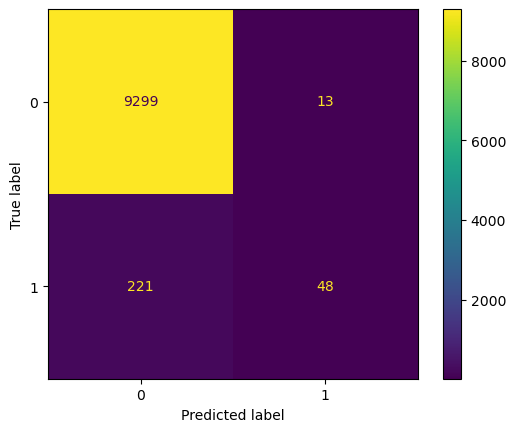

In [16]:
# confusion matrix
ConfusionMatrixDisplay.from_estimator(best_pipe_clf,X_test,y_test.map({'<=50K':0,'>50K':1}))

The model hardly predicts the minority class. This is reflected in the lower f1 score.

In [17]:
pd.Series(y_test_pred).value_counts()

0    9520
1      61
Name: count, dtype: int64

In [18]:
y_test.value_counts()

label
<=50K    9312
>50K      269
Name: count, dtype: int64

In [19]:
f1_score(y_test.map({'<=50K':0,'>50K':1}), y_test_pred)

0.2909090909090909

The imbalance is causing the model to focus too much on the majority class. What can we do to compensate for this?
As far as I know, there are three strategies:

1. Some scikit-learn models have a `class_weight` parameter, which you can use to give more importance to the minority class and help the model focus on it.
2. You can also handle imbalance by oversampling the minority class (adding more examples) or undersampling the majority class (removing examples). Another popular method is [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) (Synthetic Minority Over-sampling Technique), which creates synthetic samples of the minority class to balance the dataset.
3.  You can also adjust the classification threshold.

We'll focus on the third strategy: adjusting the classification threshold.

## 3. Adjusting the classification threshold.

We know we can manually change the classification threshold. We'll use this to see if we can improve the results for the minority class. But before that, we need to tune the hyperparameters of our model. Since we're going to change the classification threshold later, we need to do the grid search using a 'threshold-independent' evaluation metric. We've seen two examples: AUC (Area Under the Curve) and AP (Average Precision).

In [20]:
# Define the parameter grid for the decision tree
param_grid = {
    'clf__max_depth': range(3, 11),  
}

# Set up the grid search using AP (Average Precision) as the scoring metric
grid_search = GridSearchCV(pipe_tree_clf, param_grid, scoring='average_precision', cv=5, verbose=1, n_jobs=-1)

# Run the grid search on the training data
grid_search.fit(X_train, y_train.map({'<=50K':0,'>50K':1}))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'education-num',
                                                                          'capitalgain',
                                                                          'capitalloss',
                                                                          'hoursperweek']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['workclass',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1, param_grid={'clf__max_depth': range(3, 11)},
             scoring='average_precision', verbose=1)

In [21]:
best_pipe_clf = grid_search.best_estimator_

Now, for the second step, we want to maximize our chosen evaluation metric—F1 in this case—based on the classification threshold. Depending on your application, you might want to maximize other metrics, like recall, precision, or something else. But the idea remains the same: we'll adjust the classification threshold to get the best performance for the metric we care about.

In [22]:
# f1 as a function of threshold

proba = best_pipe_clf.predict_proba(X_test)[:,1]
thresholds = np.linspace(0,1,200) # 200 evenly spaced points on [0,1]

f1s = []
for threshold in thresholds:
    y_test_pred = np.zeros(len(y_test)) # vector of all zeros
    y_test_pred[proba > threshold]=1
    f1s.append(f1_score(y_test.map({'<=50K':0,'>50K':1}),
                                                       y_test_pred
                                                      )
                              )

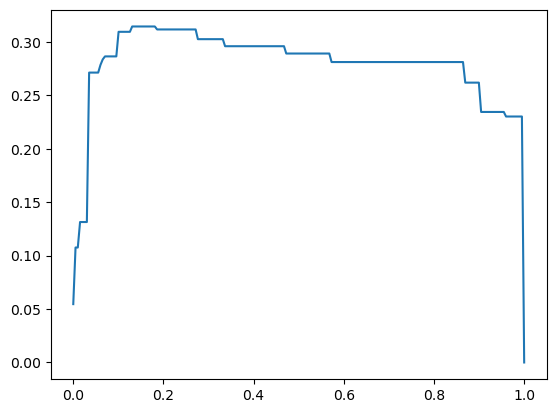

In [23]:
plt.plot(thresholds,f1s)

F1 is maximized at a very low threshold.

In [24]:
threshold = thresholds[np.argmax(f1s)]
threshold

0.1306532663316583

Now, let's use this threshold and test our model on the test set.

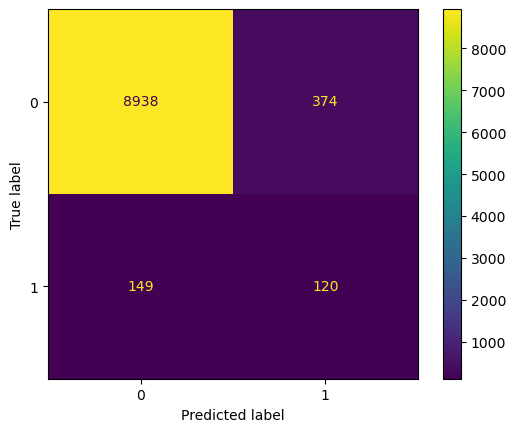

In [25]:
y_test_pred = np.zeros(len(y_test)) # vector of all zeros
y_test_pred[proba > threshold]=1
ConfusionMatrixDisplay.from_predictions(y_test.map({'<=50K':0,'>50K':1}),
                                        y_test_pred
                                        )

Now the model is finally predicting the minority class! Of course, we pay a price with a higher false positive rate, but that's a small trade-off if predicting the minority class is what matters most.

The same, but using scikit learn built-in function

In [26]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [27]:
tuned_pipe = TunedThresholdClassifierCV(estimator=best_pipe_clf, 
                                        scoring="f1",
                                       thresholds=300,
                                        n_jobs=-1)



In [28]:
tuned_pipe.fit(X_train, y_train.map({'<=50K':0,'>50K':1}))

TunedThresholdClassifierCV(estimator=Pipeline(steps=[('processor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['age',
                                                                                        'fnlwgt',
                                                                                        'education-num',
                                                                                        'capitalgain',
                                                                                        'capitalloss',
                                                                                        'hoursperweek']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['workclass',
                                                                                        'marital-status',
                                                                                        'occupation',
                                                                                        'relationship',
                                                                                        'race',
                                                                                        'sex',
                                                                                        'native-country'])])),
                                                     ('clf',
                                                      DecisionTreeClassifier(max_depth=5))]),
                           n_jobs=-1, scoring='f1', thresholds=300)

In [29]:
tuned_pipe.best_threshold_

0.16387959866220736

In [30]:
y_test_pred = tuned_pipe.predict(X_test)

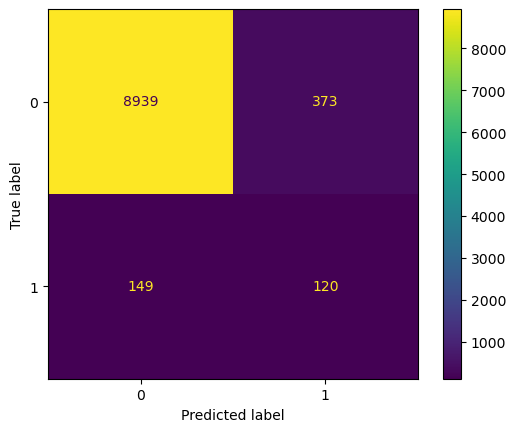

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test.map({'<=50K':0,'>50K':1}),
                                        y_test_pred
                                        )